# Gamma-gamma model

In this notebook we show how to fit a Gamma-Gamma model in PyMC-Marketing. We compare the results with the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package (not longer maintained). The model is presented in the paper: Fader, P. S., & Hardie, B. G. (2013). [The Gamma-Gamma model of monetary value](http://www.brucehardie.com/notes/025/gamma_gamma.pdf). February, 2, 1-9.


## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from lifetimes import GammaGammaFitter
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

from pymc_marketing import clv

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load Data

We will use the `CDNOW` dataset from the `lifetimes` package. For the Gamma-Gamma model, we need to filter out customers who have made only one purchase.

In [2]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()

returning_customers_summary = summary_with_money_value[
    summary_with_money_value["frequency"] > 0
]

returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


## Model Specification

Here we briefly describe the assumptions and the parametrization of the Gamma-Gamma model from the paper above.

The model of spend per transaction is based on the following three general assumptions:

- The monetary value of a customer’s given transaction varies randomly around their average transaction value.
- Average transaction values vary across customers but do not vary over time for any given individual.
- The distribution of average transaction values across customers is independent of the transaction process.
  
For a customer with x transactions, let $z_1, z_2, \ldots, z_x$ denote the value of each transaction. The customer’s observed average transaction value by

$$
\bar{z} = \frac{1}{x} \sum_{i=1}^{x} z_i
$$

Now let's describe the parametrization: 

1. We assume that $z_i \sim \text{Gamma}(p, ν)$, with $E(Z_i| p, ν) = \xi = p/ν$.

    – Given the convolution properties of the gamma, it follows that total spend across x transactions is distributed $\text{Gamma}(px, ν)$.
    – Given the scaling property of the gamma distribution, it follows that $\bar{z} \sim \text{Gamma}(px, νx)$.

2.  We assume $ν \sim \text{Gamma}(q, \gamma)$.

We are interested in estimating the parameters $p$, $q$ and $ν$.

## Lifetimes Implementation

First, we fit the model using the `lifetimes` package.

In [3]:
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(
    returning_customers_summary["frequency"],
    returning_customers_summary["monetary_value"],
)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [4]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


Once the model is fitted we can use the following method to compute the conditional expectation of the average profit per transaction for a group of one or more customers.

In [5]:
avg_profit = ggf.conditional_expected_average_profit(
    summary_with_money_value["frequency"], summary_with_money_value["monetary_value"]
)
avg_profit.head(10)

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64

In [6]:
avg_profit.mean()

35.252958176049916

## PyMC Marketing Implementation

We can use the pre-built PyMC Marketing implementation of the Gamma-Gamma model, which also provides nice plotting and prediction methods:

In [7]:
dataset = pd.DataFrame(
    {
        "customer_id": returning_customers_summary.index,
        "mean_transaction_value": returning_customers_summary["monetary_value"],
        "frequency": returning_customers_summary["frequency"],
    }
)

In [8]:
model = clv.GammaGammaModel(data=dataset)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

### Using MAP

To begin with, lets use a numerical optimzer from `scipy.optimize` to find the maximum a posteriori (MAP) estimate of the parameters.

In [9]:
model.fit(fit_method="map").posterior.to_dataframe()

,,p,q,v
chain,draw,,,
0,0,6.248787,3.744591,15.447813


These values are very close to the ones obtained by the `lifetimes` package.

### MCMC

We can also use MCMC to sample from the posterior distribution of the parameters.

In [10]:
model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

We can see some statistics of the posterior distribution of the parameters.

In [11]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.403,1.351,4.258,9.005,0.050,0.036,816.0,742.0,1.01
q,3.775,0.299,3.218,4.323,0.011,0.007,784.0,959.0,1.01
v,16.086,4.430,7.784,24.239,0.159,0.113,738.0,722.0,1.01


Let's plot the trace:

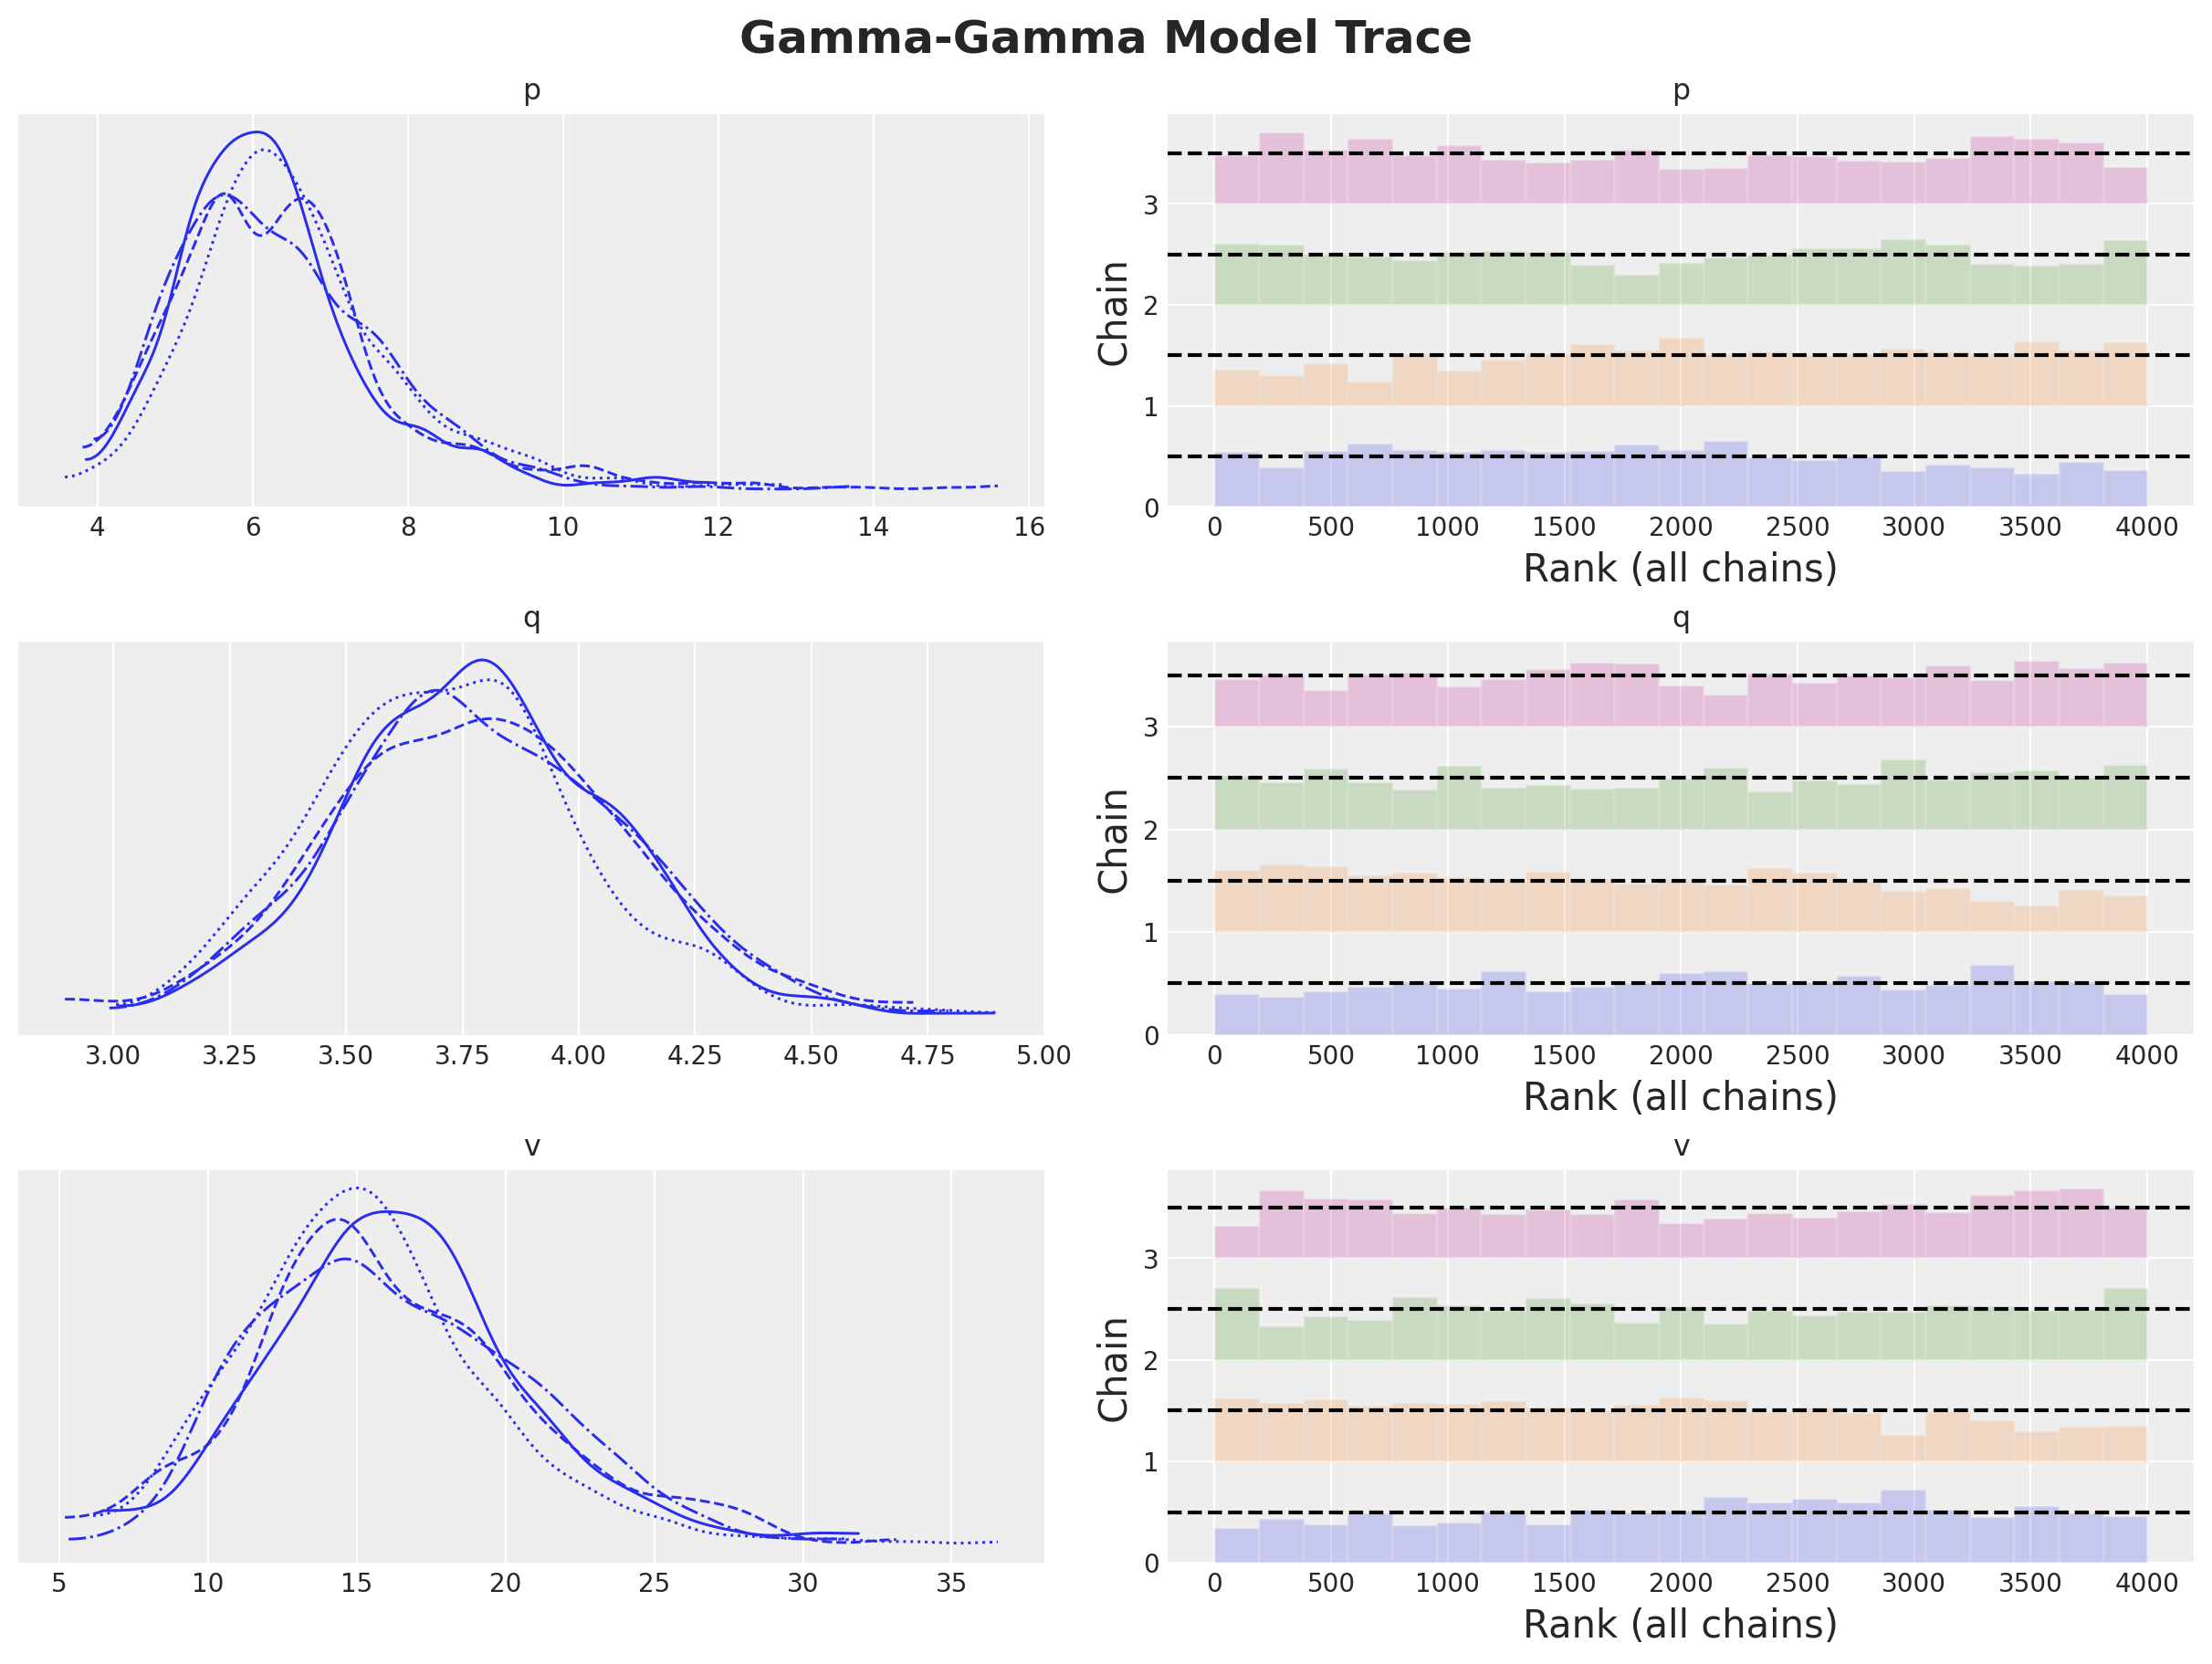

In [12]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma-Gamma Model Trace", fontsize=18, fontweight="bold");

We can compare the results with the ones obtained by the `lifetimes` package.

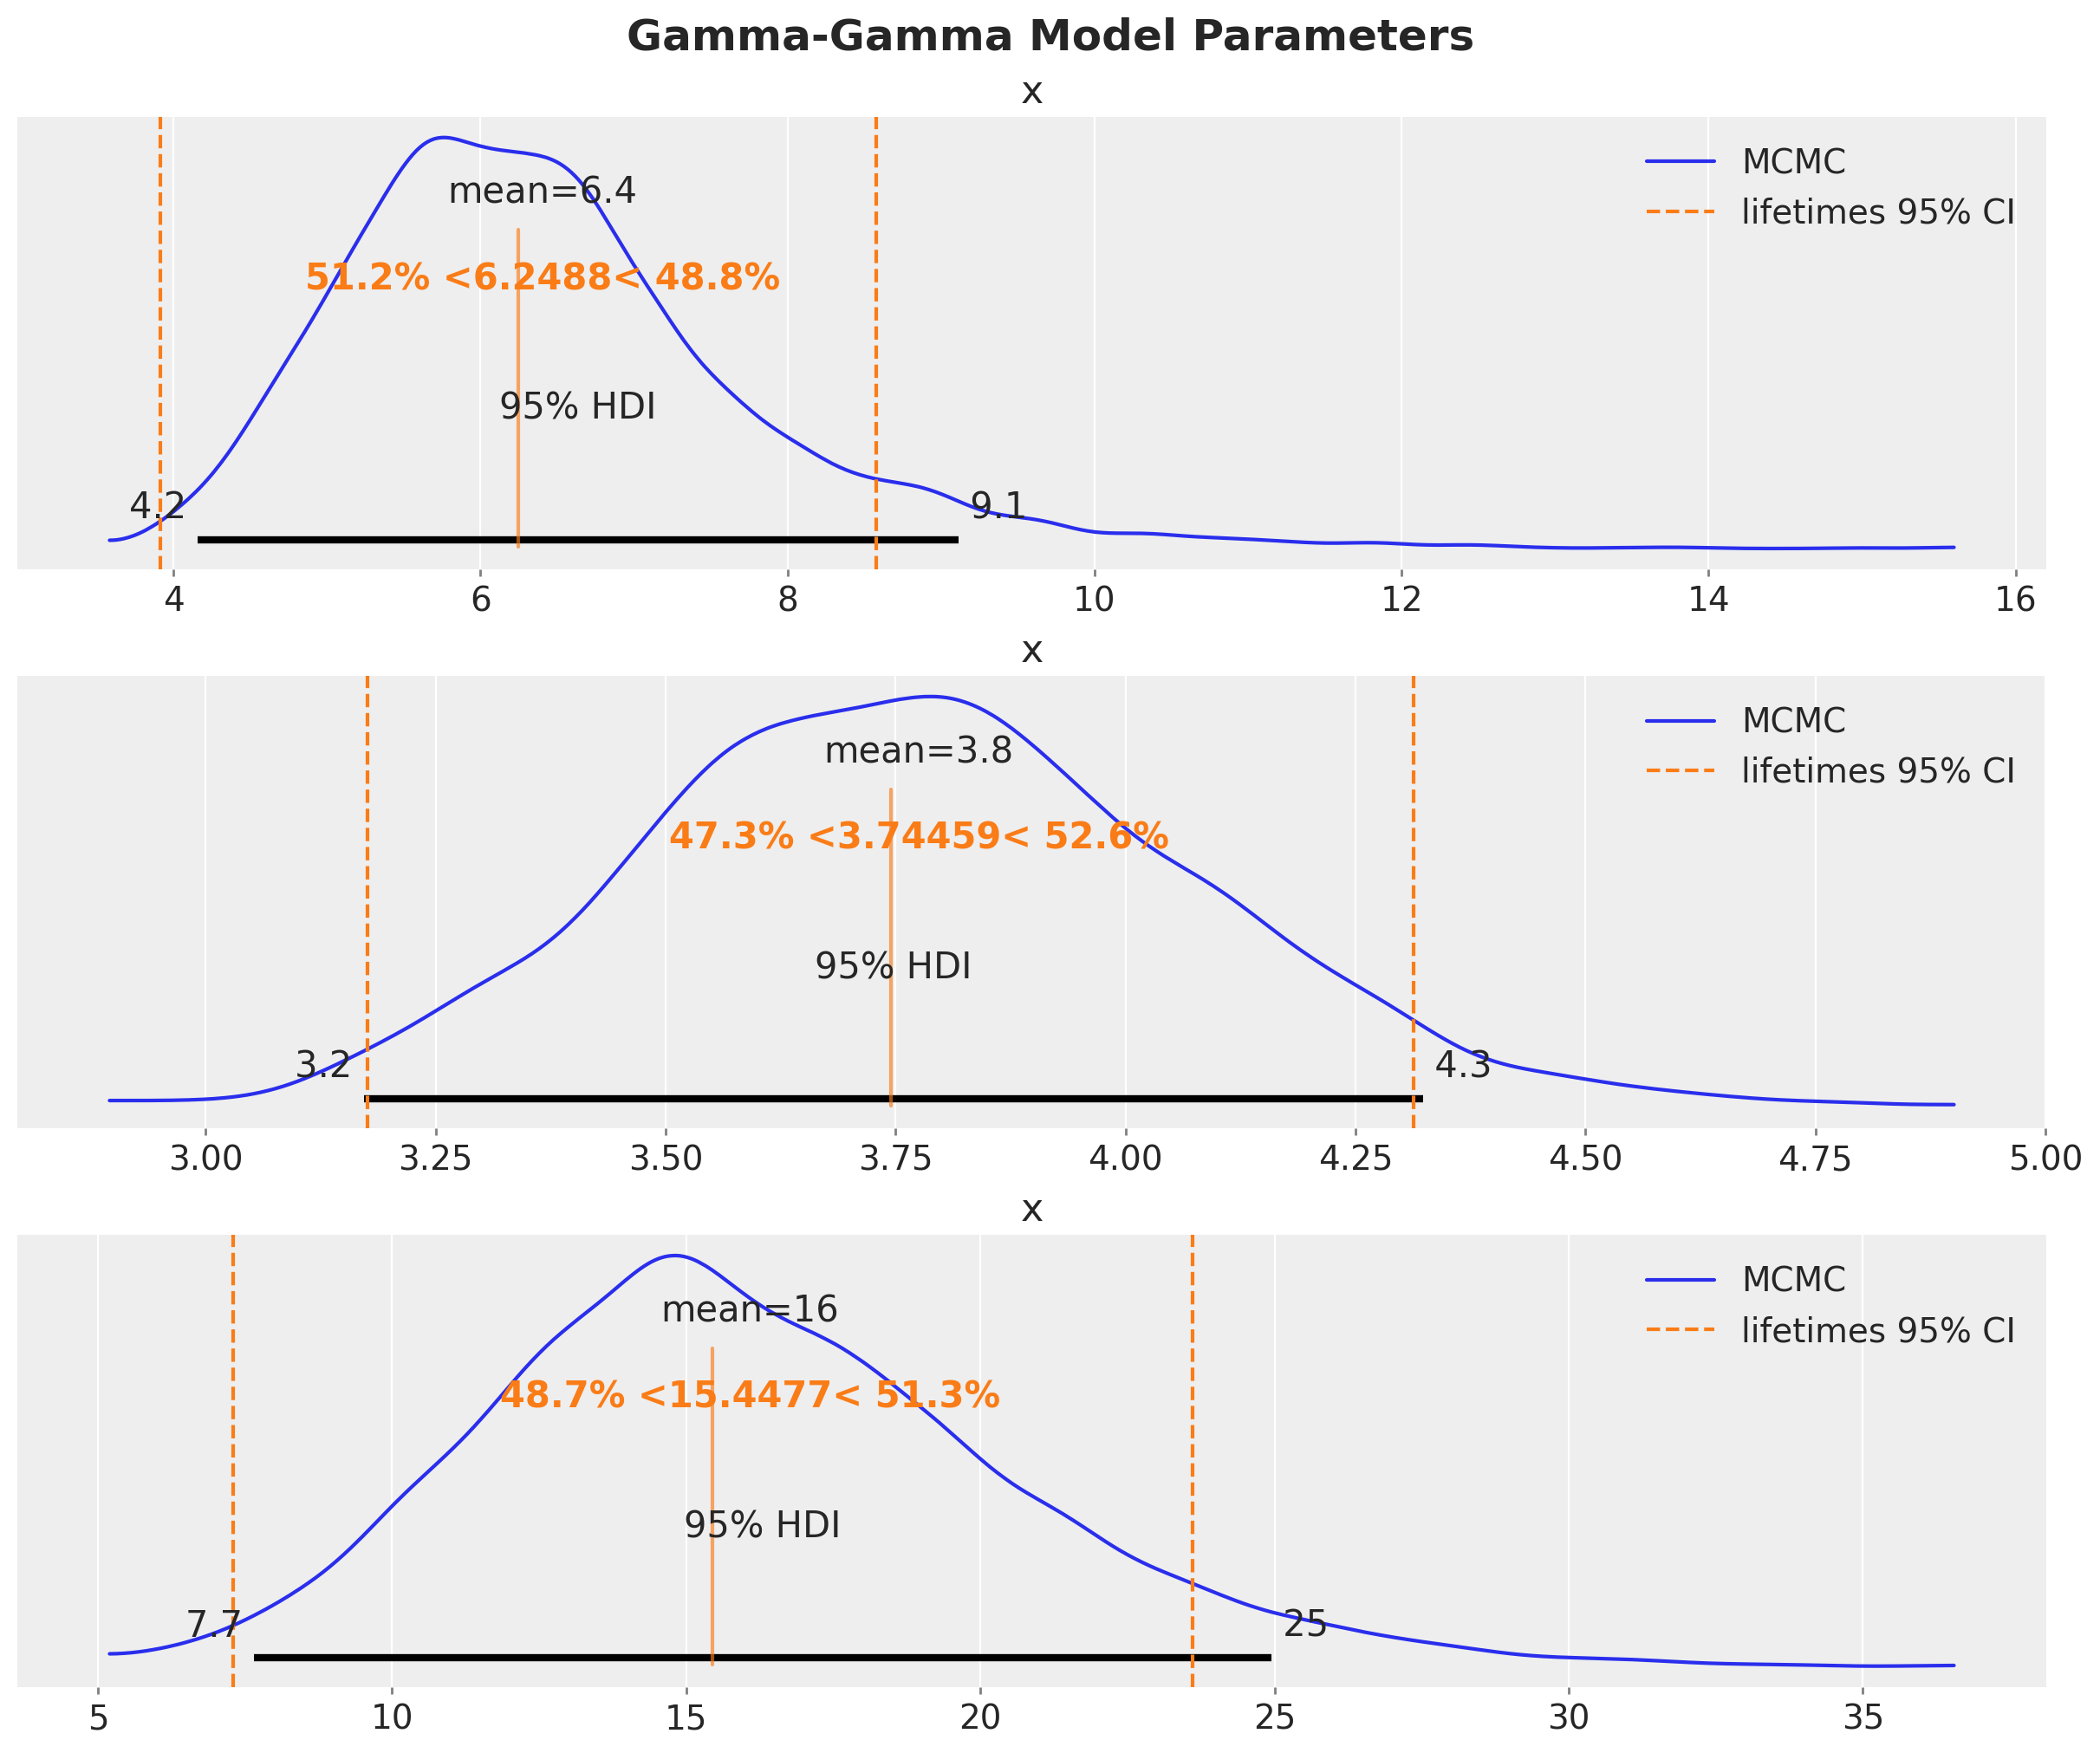

In [13]:
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(12, 10), sharex=False, sharey=False, layout="constrained"
)

for i, var_name in enumerate(["p", "q", "v"]):
    ax = axes[i]
    az.plot_posterior(
        model.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        hdi_prob=0.95,
        ref_val=ggf.summary["coef"][var_name],
        ax=ax,
        label="MCMC",
    )
    ax.axvline(
        ggf.summary["lower 95% bound"][var_name],
        color="C1",
        linestyle="--",
        label="lifetimes 95% CI",
    )
    ax.axvline(
        ggf.summary["upper 95% bound"][var_name],
        color="C1",
        linestyle="--",
    )
    ax.legend(loc="upper right")

plt.gcf().suptitle("Gamma-Gamma Model Parameters", fontsize=18, fontweight="bold");

## Expected Customer Spend

Once we have the posterior distribution of the parameters, we can use the `expected_average_profit` method to compute the conditional expectation of the average profit per transaction for a group of one or more customers.

In [14]:
expected_spend = model.expected_customer_spend(
    customer_id=summary_with_money_value.index,
    mean_transaction_value=summary_with_money_value["monetary_value"],
    frequency=summary_with_money_value["frequency"],
)

In [15]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[1],24.709,0.530,23.756,25.770
x[2],18.997,1.362,16.477,21.686
x[3],35.207,0.893,33.567,36.944
x[4],35.207,0.893,33.567,36.944
x[5],35.207,0.893,33.567,36.944
x[6],71.384,0.625,70.154,72.471
x[7],18.997,1.362,16.477,21.686
x[8],35.207,0.893,33.567,36.944
x[9],27.320,0.406,26.554,28.103
x[10],35.207,0.893,33.567,36.944


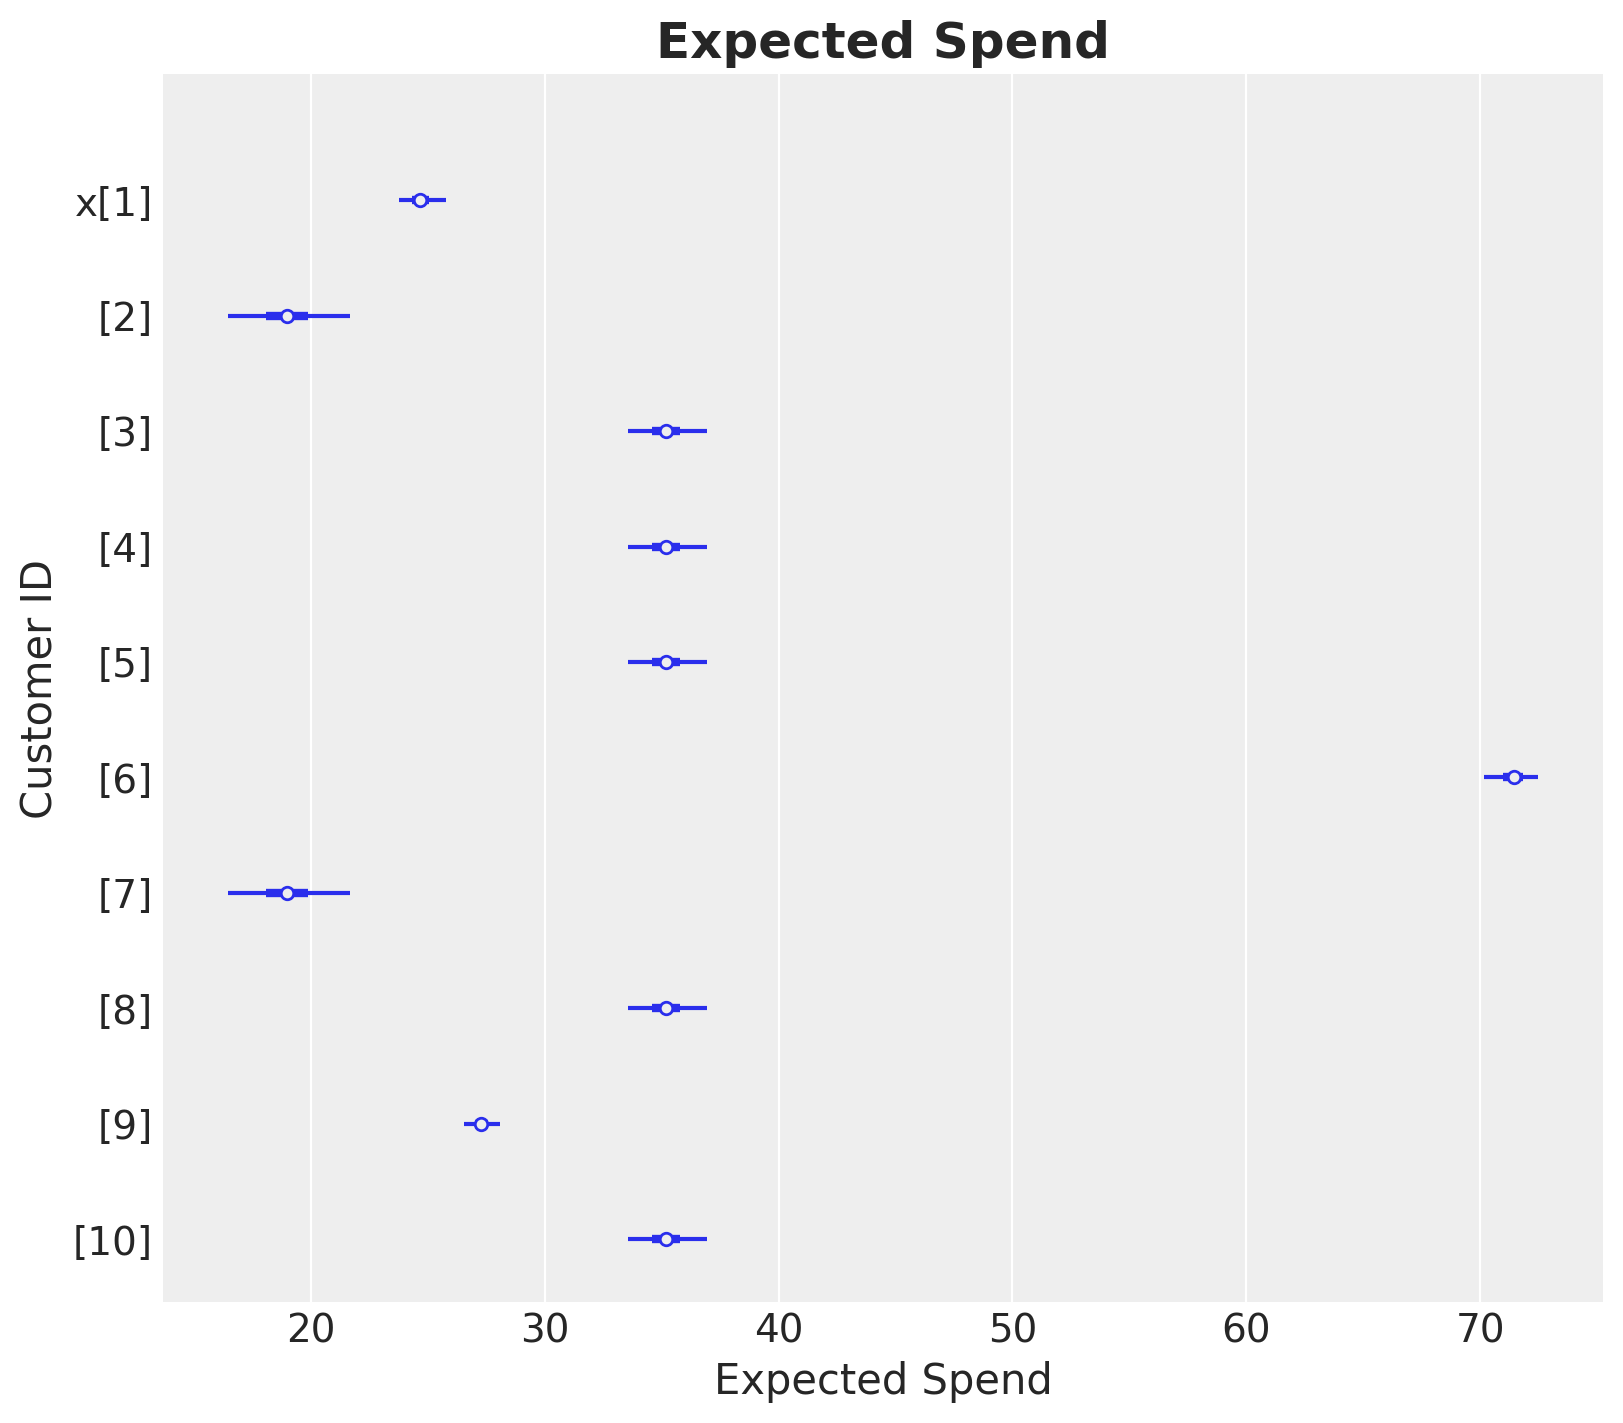

In [16]:
ax, *_ = az.plot_forest(
    data=expected_spend.isel(customer_id=(range(10))), combined=True, figsize=(8, 7)
)
ax.set(xlabel="Expected Spend", ylabel="Customer ID")
ax.set_title("Expected Spend", fontsize=18, fontweight="bold");

In [17]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,35.276,0.607,34.144,36.443


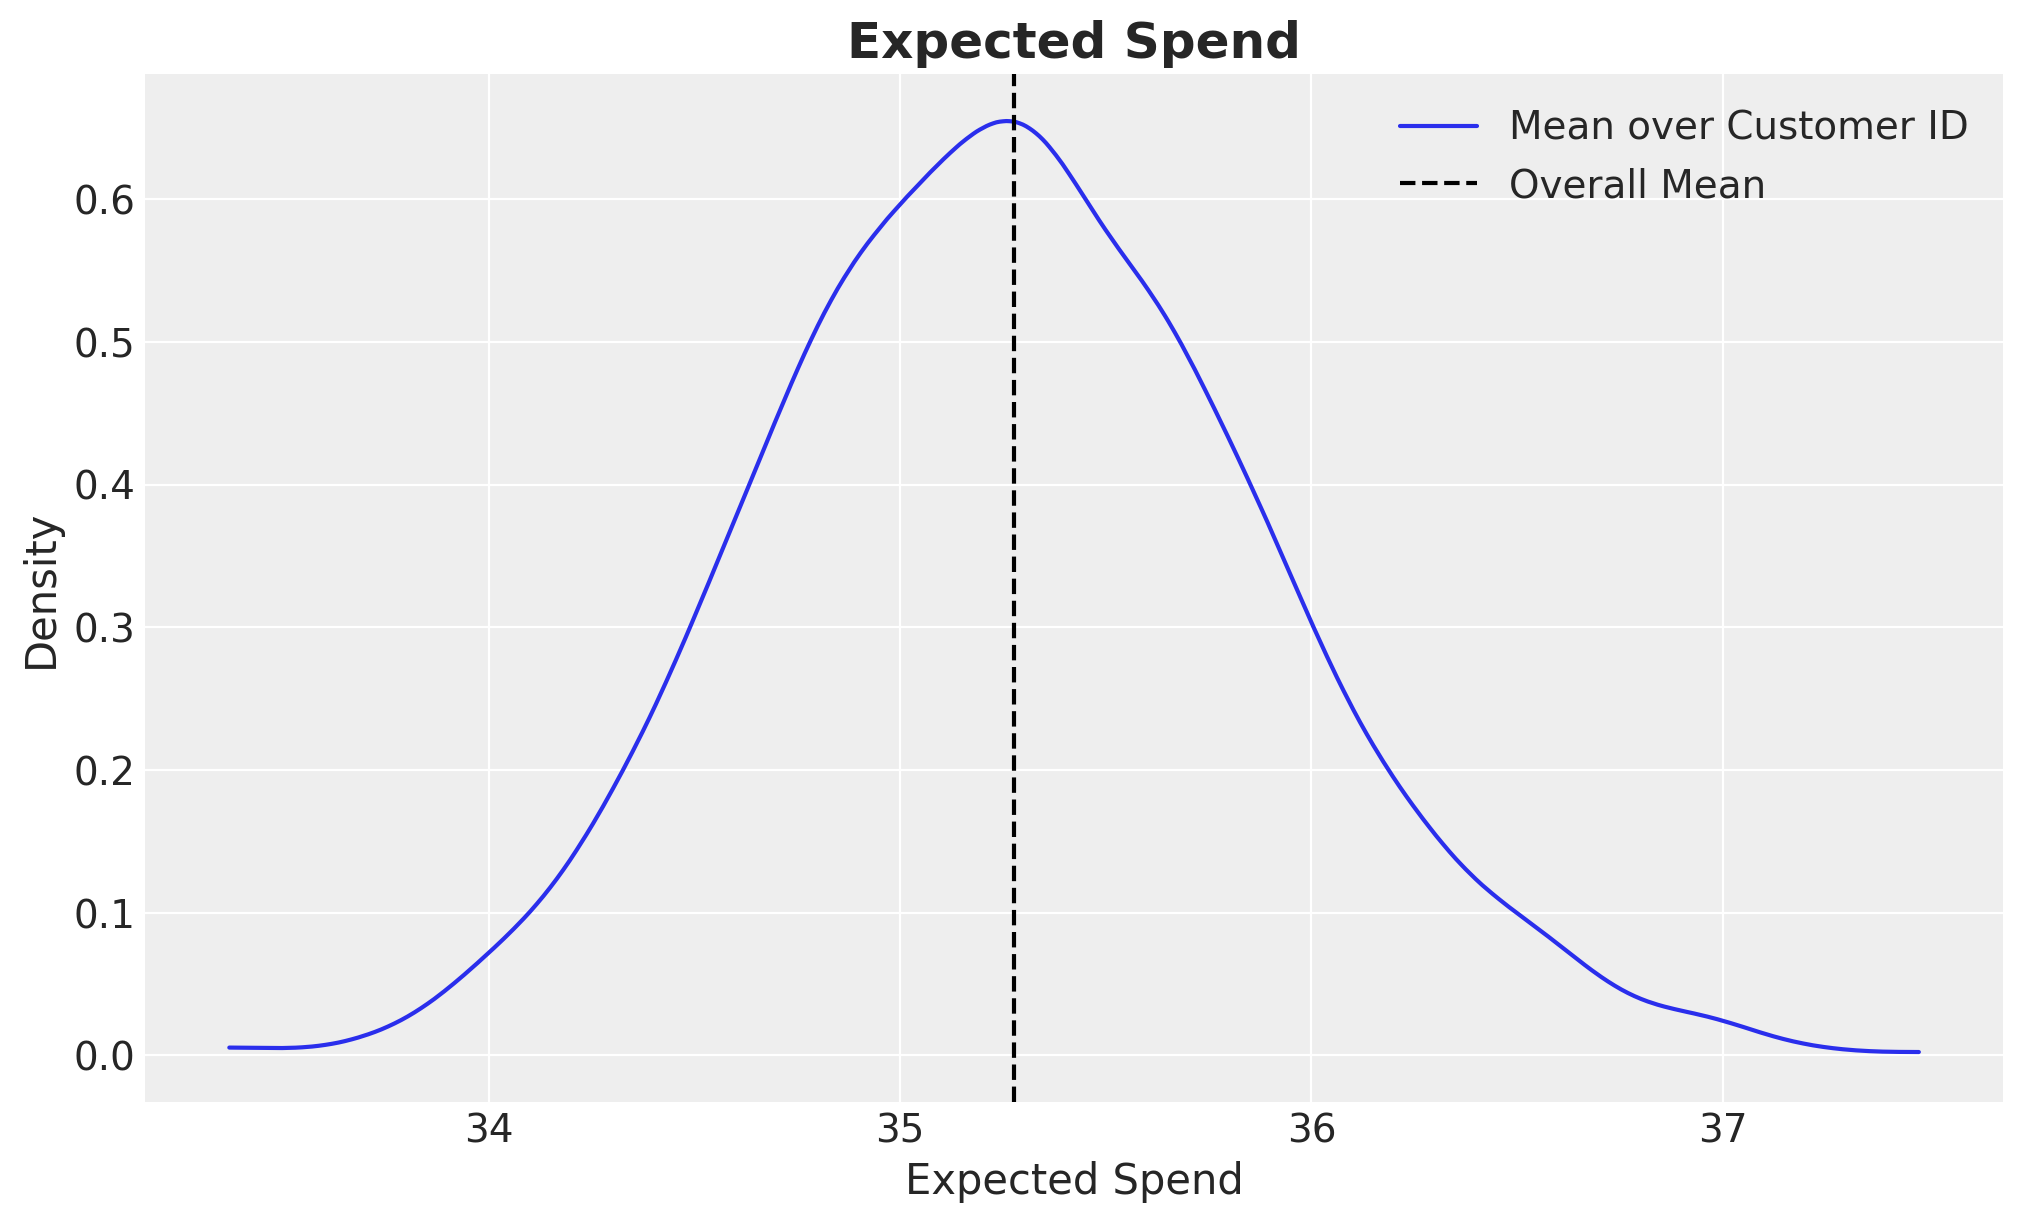

In [18]:
fig, ax = plt.subplots()
az.plot_dist(expected_spend.mean("customer_id"), label="Mean over Customer ID", ax=ax)
ax.axvline(x=expected_spend.mean(), color="black", ls="--", label="Overall Mean")
ax.legend(loc="upper right")
ax.set(xlabel="Expected Spend", ylabel="Density")
ax.set_title("Expected Spend", fontsize=18, fontweight="bold");

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Thu Mar 07 2024

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.14.0

pymc    : 5.10.4
pytensor: 2.18.6

matplotlib    : 3.7.1
pymc_marketing: 0.4.0
pandas        : 2.0.3
arviz         : 0.15.1

Watermark: 2.4.3

